In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
format_plots()
#format_pizza_plots()
c = PlotConfig()

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [6]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data = data_all.query('age<100')

In [7]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
f_data = data_all.query('age<100')

In [8]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

In [9]:
male_data=m_data.copy()
female_data=f_data.copy()

In [10]:
# process data

In [11]:
# choose a model for decoder
#clf = KNeighborsRegressor(n_neighbors=10)
#clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 100)
#clf = LinearRegression()
clf = PLSRegression(n_components=5)
# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=1000

In [12]:
# predict male age

In [13]:
#prepare data
data=male_data.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [14]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
mse_age = mean_squared_error(y_age, y_pred)
print(r2_age)

0.7921244767093674


In [15]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:40<00:00,  1.18s/it]


In [17]:
#predict female age

In [18]:
data=female_data.copy()
y_psd =data.index.get_level_values('age').to_numpy()
X=female_data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [19]:
#decoder
y_pred_psd = cross_val_predict(clf, X, y_psd, cv=cv)
r2_psd = r2_score(y_psd, y_pred_psd)
mse_psd = mean_squared_error(y_psd, y_pred_psd)
print(r2_psd)
print(mse_psd)

0.7145335502673705
207.48113341370168


In [20]:
#shuffle
ysh_score_psd=[]
ysh_psd=[]
ysh_predict_psd=[]
ysh_mse_psd=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_psd)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_psd.append(r2_score(y_psd, y_pred_temp))
    ysh_mse_psd.append(mean_squared_error(y_psd, y_pred_temp))
    ysh_psd.extend(ysh_temp)
    ysh_predict_psd.extend(y_pred_temp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:08<00:00,  1.15s/it]


In [22]:
## train regressor on male predict on female

In [23]:
## female prediction from male regressor
y_train =male_data.index.get_level_values('age').to_numpy()
X_train=male_data.to_numpy()
clf.fit(X_train, y_train)

X_test=female_data.to_numpy()
y_f_from_m = clf.predict(X_test)
r2_f_from_m = r2_score(y_psd, y_f_from_m)
print(r2_f_from_m)

0.2238102312466198


In [24]:

## male prediction from female regressor
y_train =female_data.index.get_level_values('age').to_numpy()
X_train=female_data.to_numpy()
clf.fit(X_train, y_train)


X_test=male_data.to_numpy()
y_m_from_f = clf.predict(X_test)

r2_m_from_f = r2_score(y_age, y_m_from_f)
print(r2_m_from_f)

0.6733970545710133


In [39]:
## overlay both regressors performance

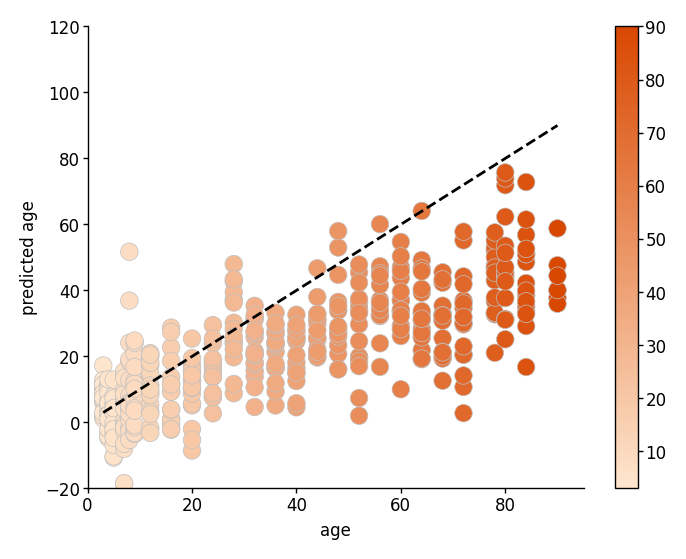

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y_psd, y=y_f_from_m, 
            s=40, 
            c=y_psd, 
            edgecolor='none',
            linewidth=0.25,
            #norm='log',
            cmap=cmf)
sns.despine()
norm = plt.Normalize(y_psd.min(), y_psd.max())
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])
plt.ylim([-20, 120])
plt.xlim([0, 95])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.plot(y_psd, y_psd, linestyle='--', color='black')
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'decoder_predicted_female_from_male.pdf', bbox_inches='tight')

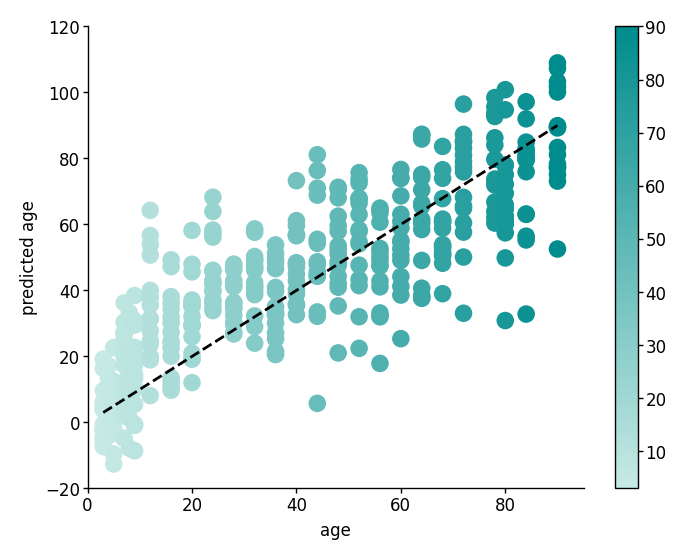

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y_age, y=y_m_from_f, 
            s=40, 
            c=y_age, 
            edgecolor='none',
            linewidth=0.25,
            #norm='log',
            cmap=cmm)
sns.despine()
norm = plt.Normalize(y_age.min(), y_age.max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])
plt.ylim([-20, 120])
plt.xlim([0, 95])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.plot(y_age, y_age, linestyle='--', color='black')
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'decoder_male_from_female.pdf', bbox_inches='tight')

In [ ]:
## plot r2 for all options

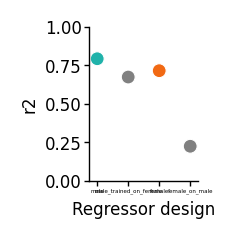

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(0.7,1)
sns.scatterplot(x=[1,2,3,4],y=[r2_age,r2_m_from_f,r2_psd,r2_f_from_m], 
                #join=False, 
              color=['#20B2AA','gray','#f16913','gray'],
              s=25)
plt.ylim([0, 1])
plt.xlim([0.75, 4.25])
plt.xlabel('Regressor design')
plt.ylabel('r2')
plt.xticks(range(1, 5))
plt.gca().set_xticklabels(['male','male_trained_on_female','female','female_on_male'],fontsize=2)
sns.despine()
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'fvm_decoders_r2.pdf', bbox_inches='tight')